### <span style="color:rgb(237,127,16)">Optimization for Machine Learning - Advanced gradient descent lectures</span>

### <span style="color:rgb(237,127,16)">Master 2 IASD & Master 2 MASH, 2021-2022</span>


# <span style="color:rgb(237,127,16)">Lab 01 - Gradient descent, acceleration and convexity</span>


Lecture notes for this course are available [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/GD/LectureNotesOML-GD.pdf).

This Jupyter notebook can be obtained [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/GD/SourcesLabGD01.zip).

For any comment regarding this notebook (including typos), please send an email to: **clement.royer@dauphine.psl.eu**.

#  <span style="color:rgb(237,127,16)">Introduction</span>

This lab session aims at illustrating the behavior of gradient descent and accelerated gradient techniques on convex 
and strongly convex problems.

*Note: All blocks of this notebook are built to be run sequentially. In particular, the next block should be executed before going any further.*

In [1]:
# Preamble: useful toolboxes, librairies, functions, etc.

# Display
%matplotlib inline
import matplotlib.pyplot as plt

from math import sqrt # Square root
from math import ceil # Ceil integer operator
from math import log # Logarithm function

# NumPy - Matrix and vector structures
import numpy as np # NumPy library
from numpy.random import multivariate_normal, randn, uniform # Probability distributions

# SciPy - Efficient mathematical calculation
from scipy.linalg import norm # Euclidean norm
from scipy.linalg import qr # QR decomposition from linear algebra

The NumPy library is used in this lab. A quick tutorial for NumPy is available 
[here](https://sebastianraschka.com/pdf/books/dlb/appendix_f_numpy-intro.pdf).

**Useful NumPy routines (check documentation for more info)**

* *transpose* matrix (i.e. two-dimensional NumPy array) transpose operator.
* *matmul* matrix-matrix product (the two matrices should have the same number of rows/columns).
* *dot* matrix-vector product (dimensions permitting), can also be used as inner product operator between two vectors with samle length.
* *np.ones((m,n))* m-by-n matrix with all components equal to 1. 
* *np.zeros((m,n))* m-by-n matrix with all components equal to 1. 
* *np.identity(n)* square identity matrix of size n.
* *np.diag(v)* diagonal matrix defined by an array representing its diagonal elements.
* *np.pi* $\pi$ constant.
* *np.inf* represents an infinite number in memory.
* *np.log* componentwise logarithm for NumPy arrays.
* *np.exp* componentwise exponential for NumPy arrays.
* *np.sum* sum of the components of a NumPy array (for matrices, works along one dimension
* *np.maximum(u,v)* returns a NumPy array as output. The components of this array are $max(u_i,v_i)$, with $u_i$ and $v_i$ being the components of $u$ and $v$.
* *np.concatenate* concatenates NumPy arrays (vectors, matrices) of appropriate dimensions.
* If t is a NumPy array, the function *t.shape* returns the dimension(s) of that array (useful when one wants to define an array with the same dimensions.)

# <span style="color:rgb(237,127,16)">Part 1 - A convex quadratic function</span>

In this notebook, we will study the following quadratic optimization problem:
$$
    \mbox{minimize}_{\mathbf{w} \in \mathbb{R}^d} q(\mathbf{w}):=\tfrac{1}{2}\mathbf{w}^T \mathbf{A} \mathbf{w},
$$
where $\mathbf{A} \in \mathbb{R}^d$ is a symmetric, positive semidefinite matrix with eigenvalues
$$
    \mu_1 \ge \dots \ge \mu_d \ge 0.
$$
This simple setting will allow us to illustrate the performance of gradient-type methods in a convex setting. 

**Question 0.** ***Justify that this function is continuously differentiable, and give a formula for its gradient.***

**Answer**

This function is polynomial (even quadratic) in every one of its variables, therefore it is continuously differentiable (it is actually $n$ times continuously differentiable for any $n$). 

For any $\mathbf{w} \in \mathbb{R}^d$, the gradient of $q$ at $\mathbf{w}$ is given 
by $\nabla q(\mathbf{w})=\mathbf{A} \mathbf{w}$.

**Question 1**. ***Show that the function is convex, and $\mu_d$-strongly convex whenever $\mu_d > 0$.***

**Answer**

The function $q$ is convex because its Hessian matrix, equal to $\mathbf{A}$ for every $\mathbf{w}$, is positive semidefinite. Another possibility to show convexity consists in establishing the convexity inequality.
$$
    \forall (\mathbf{u},\mathbf{v}), \qquad q(\mathbf{u}) 
    \ge q(\mathbf{v}) + \nabla q(\mathbf{v})^T (\mathbf{u}-\mathbf{v})
$$
This inequality holds here, since 
$$
    q(\mathbf{u}) - q(\mathbf{v}) - \nabla q(\mathbf{v})^T (\mathbf{u}-\mathbf{v}) 
    = \frac{1}{2}\mathbf{u}^T\mathbf{A}\mathbf{u} - \frac{1}{2}\mathbf{v}^T\mathbf{A}\mathbf{v} 
    - \mathbf{v}^T \mathbf{A}(\mathbf{u}-\mathbf{v})
    = \frac{1}{2}(\mathbf{u}-\mathbf{v})^T \mathbf{A} (\mathbf{u}-\mathbf{v}) \ge \mu_d \|\mathbf{u}-\mathbf{v}\|^2 \ge 0.
$$
When $\mu_d>0$, the above reasoning also establishes that the function is $\mu_d$-strongly convex.

**Question 2.** ***Show that the function $q$ has a $\mu_1$-Lipschitz continuous gradient.***

**Answer**

For any $(\mathbf{u},\mathbf{v}) \in \mathbb{R}^d$, we have 
$$
    \|\nabla q(\mathbf{u})-\nabla q(\mathbf{v})\| = \|\mathbf{A}(\mathbf{u}-\mathbf{v})\| 
    \le \| \mathbf{A}\| \|\mathbf{u}-\mathbf{v}\|.
$$

**Question 3.** ***What is the optimal value of this problem when $\mu_d>0$? When $\mu_d=0$? Explain the differences between those two cases.***

**Answer**

Since $q(\mathbf{w}) \ge 0$ for any $\mathbf{w}$ and $q(\mathbf{0})=0$, we know that the optimal value is $0$. When $\mu_d>0$, the zero vector is the only vector such that $q(\mathbf{0})=0$, hence the minimization problem has a unique solution. On the contrary, if $\mu_d=0$, the null space of $\mathbf{A}$ contains more than the zero vector, and therefore there are infinitely many solutions.

*NB: This illustrates a key difference between convex and strongly convex functions.*

In the rest of the notebook, we will reason on two different functions (hence two matrices). 

*Implementation: Generate a matrix $\mathbf{A}$ with eigenvalues randomly distributed in [$\mu$,$L$], where $L$ and $\mu$ are fixed parameters. Generate then a matrix $\mathbf{A}_0$ with its $d/2$ largest eigenvalues equal to that of $\mathbf{A}$ and the rest equal to $0$.*

In [2]:
# Block for implementation 1

# Problem size
d=100

# Lipschitz constant
L=1

# Strong convexity constant
mu=0.01

# Fix random seed for reproducibility
np.random.seed(1)

# Generate a random orthogonal matrix Q
M = np.random.multivariate_normal(np.zeros(d),np.identity(d),size=d)
Q,R = qr(M) # Q is orthogonal by definition of the QR factorization

# Generate random eigenvalues between mu and L
D = np.random.uniform(mu,L,d)
D = 10.**D
D = (D-min(D))/(max(D)-min(D))
D = mu+(L-mu)*D

D0 = D.copy()
D0[ceil(d/2):] = 0


# Produce matrix A
A = Q.T @ np.diag(D) @ Q

# Produce matrix A0 by setting the last eigenvalue to 0
A0 = Q.T @ np.diag(D0) @ Q

# <span style="color:rgb(237,127,16)">Part 2 - Gradient descent on convex and strongly convex quadratics</span>

We define the following code for gradient descent.

In [3]:
def gd(w0,A,step,n_iter=100, verbose=False): 
    """
        A code for gradient descent on quadratic functions.
        
        Inputs:
            w0: Initial vector
            A: Square matrix of same
            step: Value of the stepsize
            n_iter: Number of iterations
            verbose: Boolean value indicating whether the outcome of every iteration should be displayed
      
        Outputs:
            w_output: Final iterate of the method
            objvals: History of function values (output as a Numpy array of length n_iter+1)
            
    """
    
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # Initial value of current iterate   
    w = w0.copy()

    # Initialize iteration counter
    k=0    
    
    # Current objective
    obj = 0.5*w.dot(A.dot(w))
    objvals.append(obj);

    # Plot the initial values if asked to
    if verbose:
        print("Gradient Descent:")
        print(' | '.join([name.center(8) for name in ["iter", "fval"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8)]))
    
    ####################
    # Main loop
    while (k < n_iter):
        
        # Compute the gradient
        g = A.dot(w)
        
        # Select the stepsize and perform the update
        w[:] = w - step * g
        
        # Compute the new objective value 
        obj = 0.5*w.dot(A.dot(w))
        objvals.append(obj)
        
        # Plot relevant information if asked to
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8)]))       
        
        # Increment the iteration count
        k += 1
    
    # End main loop
    ######################
    
    # Output
    w_output = w.copy()
    return w_output, np.array(objvals)

*Implementation:* 
- *Run GD for 10 random initial points on the problem involving the matrix $\mathbf{A}$, and plot the average function value at the end of the run. Use $\tfrac{1}{L}$ 
and $\tfrac{1}{L+\mu}$ as possible stepsizes.*
- *Compare both variants on a single run.*

In [4]:
# Implementation - Running GD with 10 random initial points
nruns=10
nits=1000

u = np.array(range(nits))

avg_1 = 0
avg_2 = 0

for i in range(nruns):
    w0 = randn(d)
    wgd1, obj_gd1 = gd(w0,A,1/L,nits)
    avg_1 += obj_gd1[-1]
    wgd2, obj_gd2 = gd(w0,A,2/(L+mu),nits)
    avg_2 += obj_gd2[-1]
    
print('Average function value with 1/L:',avg_1/nruns)
print('Average function value with 2/(L+mu):',avg_2/nruns)

Average function value with 1/L: 1.3487593401278077e-11
Average function value with 2/(L+mu): 9.90276388393236e-19


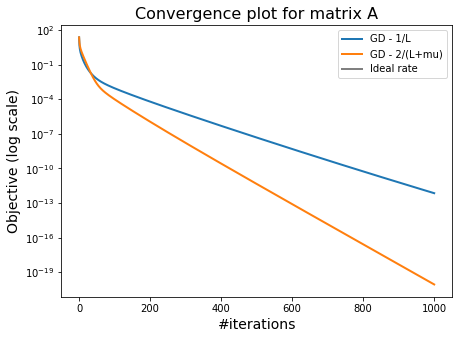

In [5]:
# Implementation - Compare both variants on 1 run
plt.figure(figsize=(7, 5))
plt.semilogy(obj_gd1, label="GD - 1/L", lw=2)
plt.semilogy(obj_gd2, label="GD - 2/(L+mu)", lw=2)
plt.semilogy(log(1-mu/L)*u, label='Ideal rate',color='gray',lw=2)
plt.title("Convergence plot for matrix A", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

*Implementation: Repeat the above steps for $\mathbf{A}_0$, using the stepsize $1/L$. This time plot all the runs*

Average on A0 (with 1/L): 0.0009692363112223424


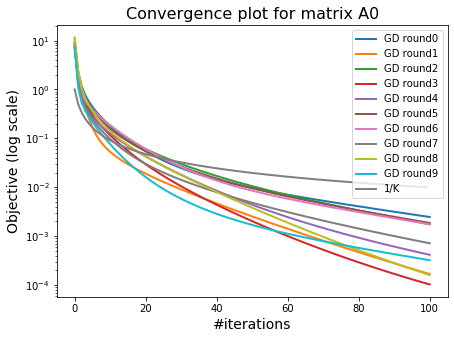

In [6]:
# Implementation - Test GD on quadratic problems with matrix A0
nruns=10
nits=100

u=np.array(range(nits))

avg_0 = 0
obj_gd0 = np.zeros((nruns,nits+1))

for i in range(nruns):
    w0 = randn(d)
    wgd0, obj_gd0[i,:] = gd(w0,A0,1/L,nits)
    avg_0 += obj_gd0[i,-1]
    
print('Average on A0 (with 1/L):',avg_0/nruns)

# Implementation - Compare both variants on 1 run
plt.figure(figsize=(7, 5))
for i in range(nruns):
    name = "GD round"+str(i)
    plt.semilogy(obj_gd0[i,:], label=name, lw=2)
plt.semilogy(1./(u+1),label='1/K',color='gray',lw=2)
plt.title("Convergence plot for matrix A0", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

***Question. What is the complexity/convergence rate of gradient descent on convex and strongly convex problems? Are those results visible in practice?***

**Answer**

Gradient descent has a convergence rate of $\mathcal{O}(1/K)$ in the convex setting, and $\mathcal{O}\left(\left(1-\frac{\mu}{L}\right)^K\right)$ in the $\mu$-strongly convex setting. The latter rate is called linear because the function $K \mapsto \ln\left((1-\mu/L)^K \right) = K \ln(1-\mu/L)$ is a linear function. The first plot above does show a linear trend (although it is not triggered until after a few iterations), so we observe this convergence rate.

Similarly, the second plot resembles an inverse trend. By plotting $K \mapsto 1/K$, we can see that the trend is indeed $1/K$, though the results are better than the theoretical convergence rate. This should not come as a surprise, as these rates (and the associated complexity bounds) express a worst-case behavior.

# <span style="color:rgb(237,127,16)">Part 3 - Accelerated methods on convex and strongly convex quadratics</span>

In this part, we will compare accelerated techniques to gradient descent. the following code is a wrapper for Polyak's heavy-ball method and the two variants of Nesterov's algorithm applied to quadratic problems.

In [7]:
# Accelerated gradient implementation
def ag(w_0,A,step,method="nesterov",momentum=None,n_iter=100,verbose=False): 
    """
        A generic code for Polyak's heavy-ball method and Nesterov's accelerated gradient method.
        
        Inputs:
            w0: Initial vector
            A: Data matrix
            step: Constant value for the stepsize
            method: Type of acceleration technique that is used
                'heavyball': Heavy-ball method
                'nesterov': Accelerated gradient for convex functions (Nesterov)
                'nesterovstrong': Accelerated gradient for strongly convex functions
            momentum: Constant value for the momentum parameter (only used if method!='nesterov')
            n_iter: Number of iterations
            verbose: Boolean value indicating whether the outcome of every iteration should be displayed
            
        Outputs:
            z_output: Final iterate of the method
            objvals: History of function values in z (output as a Numpy array of length n_iter+1)
    """
    
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    
    # Initial value of current and next iterates   
    w = w0.copy()
    w_new = w0.copy()
    z = w0.copy()
    
    if method=='nesterov':
        # Initialize parameter sequence
        tk = 0
        tkp1 = 1
        momentum = 0
 
    # Initialize iteration counter
    k=0
    
    # Initial objective
    obj = 0.5*z.dot(A.dot(z)) 
    objvals.append(obj);
    
    # Plot the initial values if required
    if verbose:
        print("Accelerated Gradient/"+method)
        print(' | '.join([name.center(8) for name in ["iter", "fval"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8)]))
    
    #######################
    # Main loop
    while (k < n_iter):
        
        # Perform the accelerated iteration
        if method=='heavyball':
            # Compute gradient
            g = A.dot(w_new)
            # Compute momentum term and update w
            z[:] = w_new - w
            w[:] = w_new[:]
            # Add momentum step
            w_new[:] = w_new -step*g + momentum*z
        else:
            # Gradient step
            g = A.dot(z)
            w_new[:] = z - step * g
            # Momentum step
            z[:] = w_new + momentum*(w_new-w)
            # Update sequence
            w[:] = w_new[:]
        
        
        # Adjusting the momentum parameter if needed
        if method=='nesterov':
            tkp1 = 0.5*(1+sqrt(1+4*(tk**2)))
            momentum = (tk-1)/tkp1
            tk = tkp1
        
        # Compute and plot the new objective value and distance to the minimum
        if method=='heavyball':
            obj = 0.5*w.dot(A.dot(w))
        else:
            obj = 0.5*z.dot(A.dot(z))
        objvals.append(obj)
        
        # Plot these values if required
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8)]))   
        
        # Increment the iteration counter
        k += 1
    
    # End loop
    #######################
    
    
    # Output
    z_output = z.copy()
          
    return z_output, np.array(objvals)

*Implementation: Consider the following methods applied to the minimization of $q$:*
- *Gradient descent with stepsize $\tfrac{1}{L}$.*
- *Heavy-ball method with stepsize $\tfrac{4}{(\sqrt{\mu}+\sqrt{L})^2}$ and momentum parameter $\tfrac{\sqrt{L}-\sqrt{\mu}}{\sqrt{L}+\sqrt{\mu}}$.*
- *Nesterov's method with stepsize $\tfrac{1}{L}$ and variable momentum parameter.*
- *Nesterov's method with stepsize $\tfrac{1}{L}$ and momentum parameter $\tfrac{\sqrt{L}-\sqrt{\mu}}{\sqrt{L}+\sqrt{\mu}}$.*

*Compare the results obtained after running the methods on 10 different initial points. Plot a representative run.*

In [8]:
# Implementation - Running all methods with 10 random initial points
nruns=10
nits=1000

beta = (sqrt(L)-sqrt(mu))/(sqrt(L)+sqrt(mu))
stephb = 4/((sqrt(mu)+sqrt(L))**2)

avg_gd = 0
avg_hb = 0
avg_n = 0
avg_ns = 0

for i in range(nruns):
    w0 = randn(d)
    w_gd, obj_gd = gd(w0,A,1/L,nits)
    avg_gd += obj_gd[-1]
    w_hb, obj_hb = ag(w0,A,stephb,'heavyball',beta,nits)
    avg_hb += obj_hb[-1]
    w_n, obj_n = ag(w0,A,1/L,'nesterov',None,nits)
    avg_n += obj_n[-1]
    w_ns, obj_ns = ag(w0,A,1/L,'nesterovstrong',beta,nits)
    avg_ns += obj_ns[-1]
    
print('Average function value for GD:',avg_gd/nruns)
print('Average function value for Heavy Ball',avg_hb/nruns)
print('Average function value for Nesterov (convex version)',avg_n/nruns)
print('Average function value for Nesterov (strongly convex version)',avg_ns/nruns)

Average function value for GD: 1.6600080685747973e-11
Average function value for Heavy Ball 3.191306787699384e-86
Average function value for Nesterov (convex version) 9.96578293561151e-13
Average function value for Nesterov (strongly convex version) 2.2304631249879394e-90


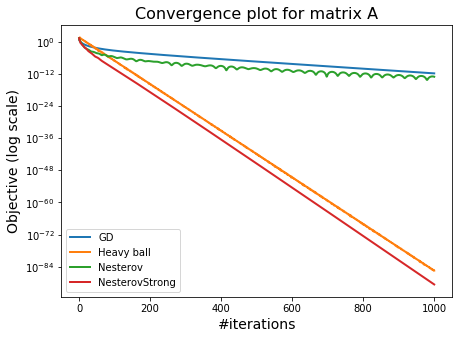

In [9]:
# Implementation - Compare both variants on 1 run
plt.figure(figsize=(7, 5))
plt.semilogy(obj_gd, label="GD", lw=2)
plt.semilogy(obj_hb, label="Heavy ball", lw=2)
plt.semilogy(obj_n, label="Nesterov", lw=2)
plt.semilogy(obj_ns, label="NesterovStrong", lw=2)
plt.title("Convergence plot for matrix A", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

**Question:** ***Comment on these results, and their agreement with the complexity theory. Plot the results for 100 and 1000 iterations. What do you observe then?***

**Answer**

First plot: Out of the two Nesterov variants, only one can achieve the optimal convergence rate for strongly convex functions. This rate is also that established for the heavy-ball method, and we do observe that both methods converge at a better rate than gradient descent, or the Nesterov method for convex problems.

Note that the picture is much clearer if we allow for a large number of iterations, but even with $100$ iterations gradient descent gets a worse convergence rate.

*Implementation: Using the convex quadratic defined by the matrix $A_0$, compare the performance of gradient descent and Nesterov's method (in its convex version).*

Average function value for GD: 4.772750776131391e-13
Average function value for Nesterov (convex version) 1.3751521465735536e-13


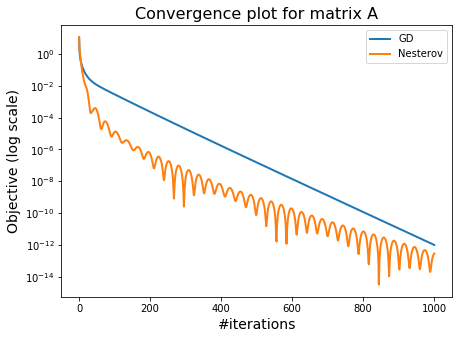

In [10]:
# Implementation - Running the methods for convex problems with 10 random initial points
nruns=10
nits=1000

u = np.array(range(nits))

avg_gd = 0
avg_hb = 0
avg_n = 0
avg_ns = 0

for i in range(nruns):
    w0 = randn(d)
    w_gd, obj_gd = gd(w0,A0,1/L,nits)
    avg_gd += obj_gd[-1]
    w_n, obj_n = ag(w0,A0,1/L,'nesterov',None,nits)
    avg_n += obj_n[-1]
    
print('Average function value for GD:',avg_gd/nruns)
print('Average function value for Nesterov (convex version)',avg_n/nruns)

# Implementation - Compare both variants on 1 run
plt.figure(figsize=(7, 5))
plt.semilogy(obj_gd, label="GD", lw=2)
plt.semilogy(obj_n, label="Nesterov", lw=2)
#plt.semilogy(1./(u+1), label="1/K",color="gray",lw=2)
#plt.semilogy(1./(u+1)**2, label="1/K^2", color="sienna", lw=2)
plt.title("Convergence plot for matrix A", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

**Question:** ***How can you explain the "bumpy behavior" of Nesterov's method? Do you still observe the desired outcome?***

**Answer**

Because Nesterov's method is not a descent method, the function value can increase at some iterations (due to the momentum term). If that happens, however, the gradient step is likely to yield a improvement on subsequent iterations, and this is what we observe.

The results show superior performance for Nesterov's method, and are much better than the theoretical convergence rates.

In [11]:
# This notebook is adapted from an exercise proposed by Stephen J. Wright at the ALOP Summer School on Optimization.
# Version 1.0 - C. W. Royer, October 2021.